# 04 Surface normal - Numpy broadcasting

* 기존 예제에서 for loop을 제거하고 Numpy의 broadcasting을 이용하여 가속한 예제입니다.
* GPU를 사용하는 Pytorch 등으로 쉽게 치환할 수 있고 더욱 빨라집니다.

In [1]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

In [2]:
def normalize(vec: np.array, eps: float = 1e-6):
    return vec / (LA.norm(vec, axis=-1, keepdims=True) + eps)


def blend(color1: np.array, color2: np.array, t_map: np.array):
    return (1.0 - t_map) * color1 + t_map * color2


def dot(v1: np.array, v2: np.array) -> np.array:
    return np.sum(v1 * v2, axis=-1, keepdims=True)

In [3]:
class Ray:
    def __init__(self, origin: np.array, direction_map: np.array) -> None:
        self.origin = origin
        self.direction_map = normalize(direction_map)

    def at(self, t_map: np.array) -> np.array:
        return self.origin + t_map * self.direction_map

* 기존 예제에서는 판별식을 이용해 근이 나오지 않으면 $t$를 계산하지 않았지만 broadcasting을 위해서 모든 $t$를 계산합니다.
  * 병렬 계산에서 분기를 만드는 것보다 한 번에 계산하는 것이 계산 속도가 빠릅니다.
* sqrt 함수의 입력으로 음수가 들어갈 경우 warning이 발생하기 때문에 0 보다 작을 경우 0으로 치환해 계산하고 판별식을 이용해 필터링 합니다.

In [4]:
def is_hit_sphere(center: np.array, radius: float, ray: Ray) -> np.array:
    dir_center_to_origin = ray.origin - center

    a_map = dot(ray.direction_map, ray.direction_map)
    half_b_map = dot(dir_center_to_origin, ray.direction_map)
    c_map = dot(dir_center_to_origin, dir_center_to_origin) - radius**2.0

    discriminant = half_b_map**2 - a_map * c_map
    safe_discriminant = np.where(discriminant < 0.0, 0.0, discriminant)
    return np.where(
        discriminant < 0.0, -1.0, (-half_b_map - np.sqrt(safe_discriminant)) / a_map
    )

In [5]:
def ray_color(ray: Ray) -> np.array:
    sphere_center = np.array([0.0, 0.0, -1.0])
    hit_map = is_hit_sphere(center=sphere_center, radius=0.5, ray=ray)
    sphere_color = 0.5 * (normalize(ray.at(hit_map) - sphere_center) + 1.0)

    t_map = 0.5 * (ray.direction_map[..., 1:2] + 1.0)
    color1 = np.array([1.0, 1.0, 1.0])
    color2 = np.array([0.5, 0.7, 1.0])
    background_color = blend(color1=color1, color2=color2, t_map=t_map)

    return np.where(hit_map >= 0.0, sphere_color, background_color)

이후의 구현은 이전과 동일합니다.

In [6]:
# image
aspect_ratio = 16.0 / 9.0
image_width = 320
image_height = int(image_width / aspect_ratio)

In [7]:
# camera
viewport_height = 2.0
viewport_width = aspect_ratio * viewport_height
focal_length = 1.0

camera_origin = np.array([0.0, 0.0, 0.0])
horizontal_vec = np.array([viewport_width, 0.0, 0.0])
vertical_vec = np.array([0.0, viewport_height, 0.0])
frontal_vec = np.array([0.0, 0.0, focal_length])
lower_left_corner = (
    camera_origin - horizontal_vec / 2.0 - vertical_vec / 2.0 - frontal_vec
)

In [8]:
%%time 

us = np.linspace(start=0.0, stop=1.0, num=image_width)
vs = np.linspace(start=0.0, stop=1.0, num=image_height)
u_map, v_map = np.meshgrid(us, vs, indexing="xy")
u_map = u_map[..., np.newaxis]
v_map = v_map[..., np.newaxis]

ray = Ray(origin=camera_origin,
          direction_map=(lower_left_corner + u_map*horizontal_vec + v_map*vertical_vec) - camera_origin)

image = ray_color(ray=ray)

CPU times: total: 15.6 ms
Wall time: 19 ms


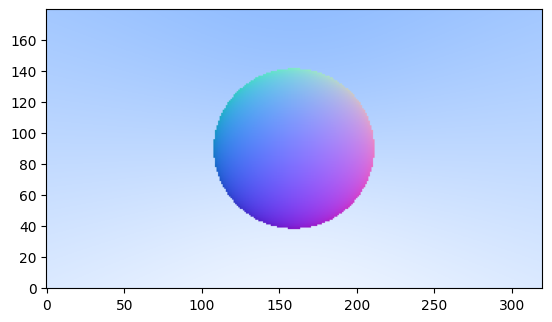

In [9]:
plt.imshow(image, origin='lower')
plt.show()